# Homework 1 - Gradient Vanish

Goals:

1. Solve vanishing gradient problem  
2. Basic usage of keras

## 1. Vanishing Gradient 



### 1.1 Definition

Normally, we use **backpropagation** to perform **gradient-based methods**.  In a neural network, each neuron receives error signal back-propagated from its next layer and uses it to compute its own gradient. And then the error will be back-propagated all the way to the first layer. Throughout the propagation, **the error signal will decay from output layer to input layer**.

### 1.2 Proof
Consider the gradient of loss for each weight : 

$$
\frac{\partial\ loss}{\partial W_o} = \frac{\partial\ output}{\partial W_o} \times \frac{\partial\ loss}{\partial\ output}
$$

$$
\frac{\partial\ loss}{\partial W_n} = \frac{\partial h_n}{\partial W_n} \times \frac{\partial\ output}{\partial h_n} \times \frac{\partial\ loss}{\partial\ output}
$$

$$
\frac{\partial\ loss}{\partial W_{n-1}} = \frac{\partial h_{n-1}}{\partial W_{n-1}} \times 
\frac{\partial h_n}{\partial h_{n-1}} \times \frac{\partial\ output}{\partial h_n} \times \frac{\partial\ loss}{\partial\ output}
$$

$$
\frac{\partial\ loss}{\partial W_{n-2}} = \frac{\partial h_{n-2}}{\partial W_{n-2}} \times 
\frac{\partial h_{n-1}}{\partial h_{n-2}} \times \frac{\partial h_{n}}{\partial h_{n-1}} \times \frac{\partial\ output}{\partial h_n} \times \frac{\partial\ loss}{\partial\ output}
$$

$$
.\\.\\.
$$

We can summarize the above as follows :

$$
\frac{\partial\ loss}{\partial W_i} = \frac{\partial h_i}{\partial W_i} \times \prod_{k=i}^{n} \frac{\partial h_{k+1}}{\partial h_k} \times \frac{\partial\ loss}{\partial\ h_{n+1}} \\
where\ \ h_{n+1} = output
$$

Let's focus on :
$$
\frac{\partial h_{k+1}}{\partial h_k}
$$

If we use sigmoid function as activation function in hidden layers, we can treat the above equation as follows :

$$
\frac{\partial h_{k+1}}{\partial h_k} = \frac{sigmoid(h_k W_k + b_k)}{\partial h_k} = W_k \times sigmoid'(h_k W_k + b_k)
$$

The output value of derivative of sigmoid function is between 0 and 0.25. This means if the value of $W_k$ is not larger than 4, the value of $\frac{\partial h_{k+1}}{\partial h_k}$ will be smaller than 1. But it is impossible to keep all $W$ larger than 4. So, we can expect that $\frac{\partial h_{k+1}}{\partial h_k}$ is always smaller than 1.

According to the above conclusions, let's go back to the equation of the gradient :

$$
\frac{\partial\ loss}{\partial W_i} = \frac{\partial h_i}{\partial W_i} \times \prod_{k=i}^{n} \frac{\partial h_{k+1}}{\partial h_k} \times \frac{\partial\ loss}{\partial\ h_{n+1}} \\
where\ \ h_{n+1} = output
$$

If $i$ is small(0, 1, 2...), the value of $\prod$ term will be also close to 0 (since multiply many values that are smaller than 1). And this means the overall gradient will be close to 0.

### 1.3 Disadvantage

Q: Why vanishing gradient is a problem ?

A: It takes more time to train a model, because learning speed is slow at the initial layers.

## 2. Practices

In this section, we will train a model with MNIST dataset and observe vanishing gradient problem.

### 2.1 MNIST

MNIST dataset contains 70000 examples of handwritten digits (60000 examples for training, 10000 examples for testing) for 10 categories (0 ~ 9). Each example is a grayscale 28 pixels x 28 pixels image. For more introduction, see [official website](http://yann.lecun.com/exdb/mnist/)

Execute the following cell to check some examples :

Using TensorFlow backend.


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


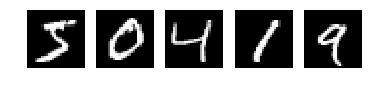

In [1]:
import numpy as np

# Keras has built-in mnist dataset
from keras.datasets import mnist
from matplotlib import pyplot as plt

%matplotlib inline

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

fig = plt.figure()

for i in range(5):
    fig.add_subplot(1, 5, i + 1)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.axis('off')
 
plt.show()

## 2.2 Preprocessing

Now, we want to train a neural network. We can treat all of pixels of a sample as features. So, there will be $28 \times 28 = 784$ features in each sample.

In this section, we will reshape each sample (2D) to a feature vector (1D) and normalize the vector. For each label, we will generate the one-hot vector.

In [1]:
import numpy as np
from keras.utils import to_categorical
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape and normalize
x_train = np.reshape(x_train, [-1, 784]) / 255.0
x_test = np.reshape(x_test, [-1, 784]) / 255.0

# One-hot encoding. See https://keras.io/utils/#to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Using TensorFlow backend.


(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


## 2.3 Neural network with single hidden layer

We can train a neural network as follows. Here, we use a custom callback to observe gradients at each layers.

The parameters of `GradientLogger`:
- x_eval (numpy array): Features to compute gradient.
- y_eval (numpy array): Labels to compute gradient.
- layer_index (list): A list of number. GradientLogger will show the distrbution of gradient of layers in those index. Set it to `None` to show all layers. Default is `None`
- keep_last_epochs (int): GradientLogger will plot histogram of the gradient in last `n` epochs. Default is `3`

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 1s 24us/step - loss: 2.1678 - acc: 0.3805 - val_loss: 2.0280 - val_acc: 0.5825
Gradient Distribution:
Name                Mean         Std
dense_1/kernel:0    0.0000058517 0.0007882272
dense_2/kernel:0   -0.0000000002 0.0076651219
Epoch 2/5
48000/48000 [==============================] - 1s 22us/step - loss: 1.9163 - acc: 0.6300 - val_loss: 1.7873 - val_acc: 0.7084
Gradient Distribution:
Name                Mean         St

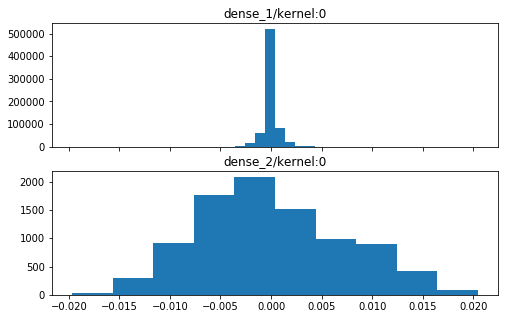

10000/10000 [==============================] - 0s 21us/step
Test accuracy: 0.7917


In [5]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense

# GradientLogger is a custom callback for keras
from helper import GradientLogger

K.clear_session()

model = Sequential()

# `input_shape` or `input_dim` should be define in the first layer.
# See https://keras.io/getting-started/sequential-model-guide/ 
model.add(Dense(300, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

# Show model architecture.
model.summary()

# Generate instance of GradientLogger. We use 200 test samples to compute gradient.
gradient_logger = GradientLogger(x_eval=x_train[:200], y_eval=y_train[:200])

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Put `gradient_logger` in `callbacks`. We only train 5 epochs.
model.fit(x_train, y_train, batch_size=256, epochs=5, validation_split=0.2, callbacks=[gradient_logger])
print('Test accuracy:', model.evaluate(x_test, y_test)[1])

Check the above histogram. We can see that gradients are close to 0 in the first layer. And we can see that test accuracy has reached 80%.

Now, let's train a neural network with two hidden layers.

## 2.4 Neural network with two hidden layers

We use the same code in section 2.3. And we only add an extra hidden layer to our model.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 1s 27us/step - loss: 2.2986 - acc: 0.1176 - val_loss: 2.2814 - val_acc: 0.1099
Gradient Distribution:
Name                Mean         Std
dense_1/kernel:0   -0.0000004126 0.0002209630
dense_2/kernel:0   -0.0000123088 0.0007993481
dense_3/kernel:0    0.0000000002 0.0072232713
Epoch 2/5
48000/

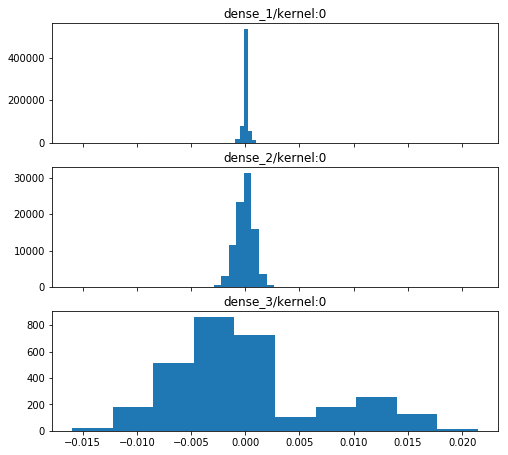

10000/10000 [==============================] - 0s 24us/step
Test accuracy: 0.4456


In [4]:
K.clear_session()

model = Sequential()

model.add(Dense(300, activation='sigmoid', input_shape=(784,)))
# Add an extra hidden layer
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.summary()

gradient_logger = GradientLogger(x_eval=x_train[:200], y_eval=y_train[:200])

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=256, epochs=5, validation_split=0.2, callbacks=[gradient_logger])
print('Test accuracy:', model.evaluate(x_test, y_test)[1])

We can see that both of train accuracy and validation accuracy drop to 50%. We spent the same time to train a more complex model. But we get a underfitting result.

# 3. Solve gradient vanish

## 3.1 Your Method

Here is your turn. You should modify the following cell to solve vanishing gradient problem and improve the test accuracy.

You should achieve the following conditions :
- Fix vanishing granient problem (40%)
- Improve test accuracy to at least 90% (30%)

Limitation :
1. You can only use sgd (stochastic gradient descent) optimizer.
2. The maximum number of epochs is 10.
3. Use at least two hidden layers

In [ ]:
K.clear_session()

model = Sequential()

model.add(Dense(300, activation='sigmoid', input_shape=(784,)))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

gradient_logger = GradientLogger(x_eval=x_train[:200], y_eval=y_train[:200])

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=256, epochs=5, validation_split=0.2, callbacks=[gradient_logger])
print('Test accuracy:', model.evaluate(x_test, y_test)[1])

## 3.2 Q & A

Please answer the following questions :

1. How does your method solve vanishing gradient problem ? (20%)

2. Read the issue of keras: [memory leak when using tensorflow](https://github.com/keras-team/keras/issues/2102). Explain why `K.clear_session()` is put in the code cell. (10%)

# 4. Bonus (20%)

Train a neural network with **50 hidden layers** in **10 epochs**. 

- Let your model score at least **90%** test accuracy. (15%)
- Explain why your method works. (5%)

In [20]:
K.clear_session()